# PS18_09_Leg1_DiMarco

CRUISE DATES    : 2017/09/22 22:12:17 to 2017/09/22 22:10:14

Run this from `~/adcp_processing/processed_data/ps1809l1`. All paths are relative to here.

Note that images have been stored in a github issue so that they can be referenced inline here without actually being stored in the repository. Interactive lines have been commented out so that all cells can be run without interference.

In [1]:
import os
%matplotlib inline
from IPython.display import display, Image
from glob import glob
import matplotlib.pyplot as plt


# define aliases for use within notebook
%alias dv pythonw ~/miniconda3/envs/adcp/bin/dataviewer.py
%alias fv pythonw ~/miniconda3/envs/adcp/bin/figview.py

In [2]:
# these are specific to this notebook
cruiseid = 'ps1809l1'
device = 'wh300'

## Looked at existing processing that occurred on the ship

Define path to cruise data processing directory, and give that to `dataviewer` (via the alias) to look at the data. This will pop up in another window.

In [3]:
# for accessing original data
procpathorig = os.path.join('/Users', 'kthyng', 'Documents', 'data_processed', 'adcp', cruiseid, cruiseid, 'proc', device)
# procpathorig = os.path.join('..', '..', '..', '..', 'data_processed', 'adcp', cruiseid, cruiseid, 'proc', device)

# for accessing post-processing of data
procpath = os.path.join('/'.join(procpathorig.split('/')[:-2]) + '_postproc', device)

# root of post-processing directory
procpathroot = '/'.join(procpathorig.split('/')[:-2]) + '_postproc'

In [4]:
# Here is how to can interactively look at the data
# dv $procpathorig

## (1) Get instructions to follow and move things around

We make a copy of the data in a `postproc` directory. The `quick_adcpy` command brings up a bunch of helpful instructions, which we move to be alongside the data directory copy.

The numbers including in headings refer to the numbers in the log file.

In [5]:
# Copy original data to new parallel location so that we can work on it.
# Preserve instrument directory in case we have more than one.
!rsync -r $procpathorig $procpathroot

In [6]:
# This is to catch the output from the following cell command
logfile = os.path.join(procpathroot, device + '.txt')  # make logfile in new processing directory

In [7]:
# get helpful instructions, capture them into "filename", and move "filename" into the data_postproc directory
!quick_adcp.py --commands postproc > $logfile

In [8]:
# prepend the log file with the cruise info
temppath = os.path.join(procpath, 'cruise_info.txt') # path to cruise_info file
!cat $temppath $logfile  > tempfile.txt  # prepend cruise_info then logfile into new file
!mv tempfile.txt $logfile                # move new file into old logfile

In [9]:
# also save copy of cruise_info.txt here for reference
!cat $temppath 

LAST CHANGED    : 2017/09/27 11:59:42
CRUISE NAME(S)  : PS18_09_DiMarco_Leg1_ADCP
CRUISE DATES    : 2017/09/22 22:12:17 to 2017/09/22 22:10:14
SHIP NAME       : unspecified
PORTS           : unspecified
CHIEF SCIENTIST : unspecified
DATABASE NAME   : a_ps
DATA FILES      : ps2017_264_79809.raw to ps2017_269_36000.raw

STATUS          :  to do                           done
                  ------                       -----------
                  averaged                       [     ]
                  loaded                         [     ]

                  NOTE: heading correction instrument exists
                        NOTE: time-dependent heading corrections
                        applied IN the ensembles
                        (see   cal/rotate/ens_hcorr.ang)

                  check heading correction       [     ]
                  calibration                    [     ]
                  edited                         [     ]
                  re-check heading correction 

In [10]:
# This might only works on Mac/Linux
# change default cruise name in file to this cruise name
!sed -i "" -e 's/km1001c/$cruiseid/g' $logfile
# change default instrument name in file to this instrument
!sed -i "" -e 's/os38nb/$device/g' $logfile

In [11]:
# The instructions are located in:
print(logfile)

/Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.txt


In [12]:
# look at the cruise track to see what we're expecting
# can do the following in a terminal window:
# plot_nav.py $procpath

Here is what the cruise track looks like:

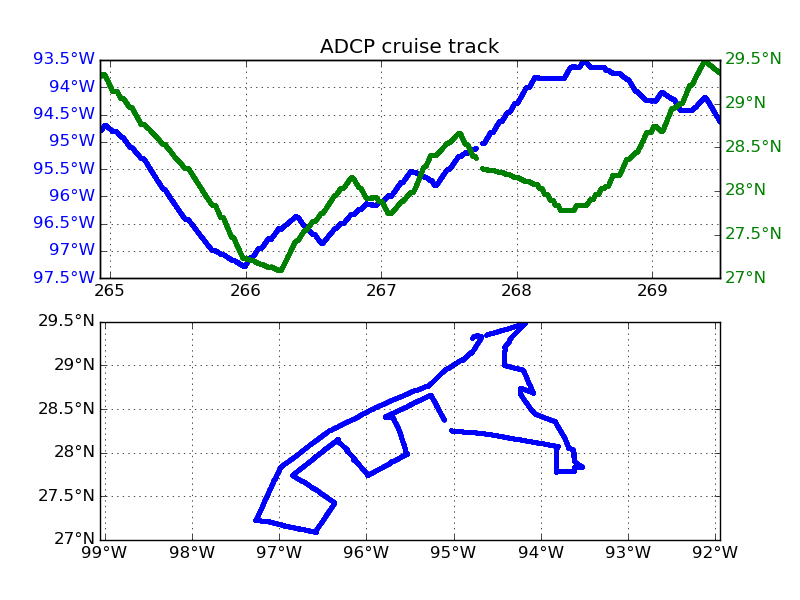

In [13]:
display(Image(os.path.join(procpath, 'nav', 'nav_plot.png'), width=600))

## (2) check accurate heading device (POSMV):

Look at figures in `~/cal/rotate/ens_hcorr_*.png` for gaps or red markers indicating problems.

This can be done with the following in the terminal window or here to browse the images, but they are also included below.

The images indicate that there are major issues with the heading. There are gaps in the heading correction.

In [14]:
path = os.path.join(procpath, 'cal', 'rotate', 'ens_hcorr_*.png')

In [15]:
# Run this to pull up a window to look at the images; also shown below.
#fv $path

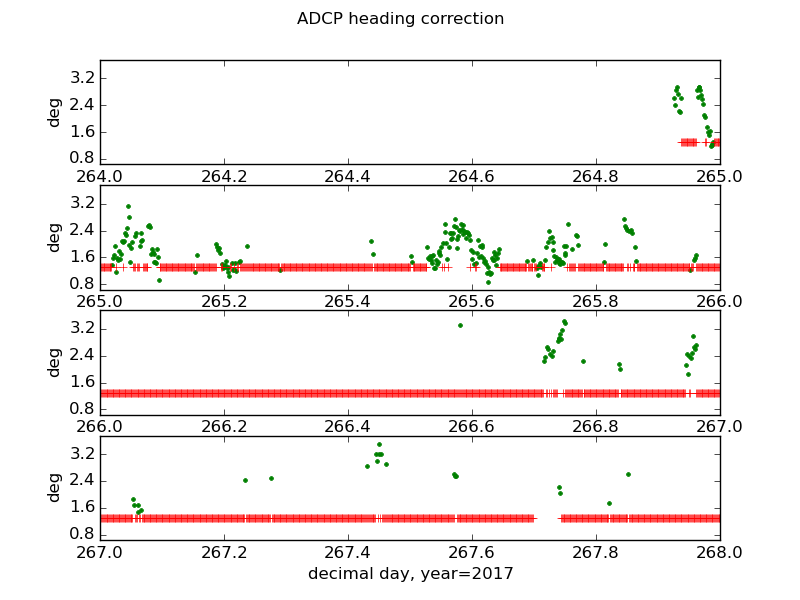

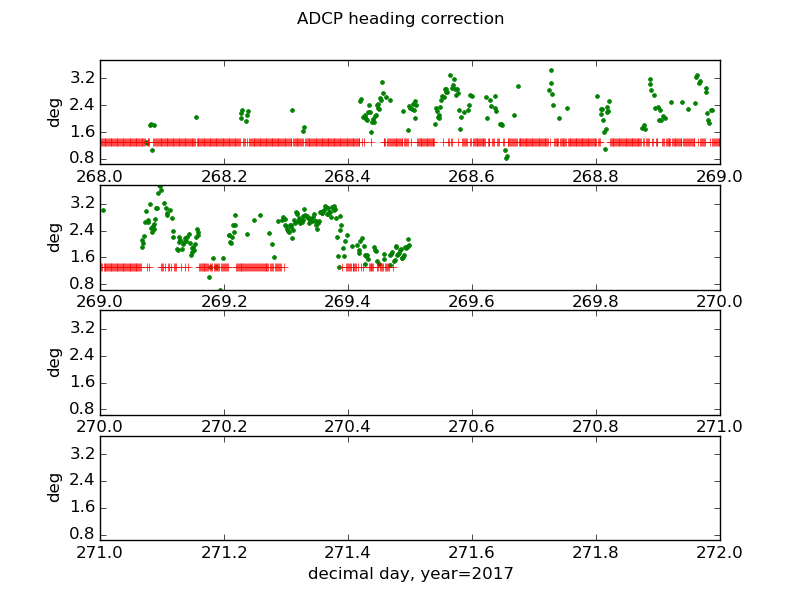

In [16]:
names = glob(path)
[display(Image(name, width=600)) for name in names];

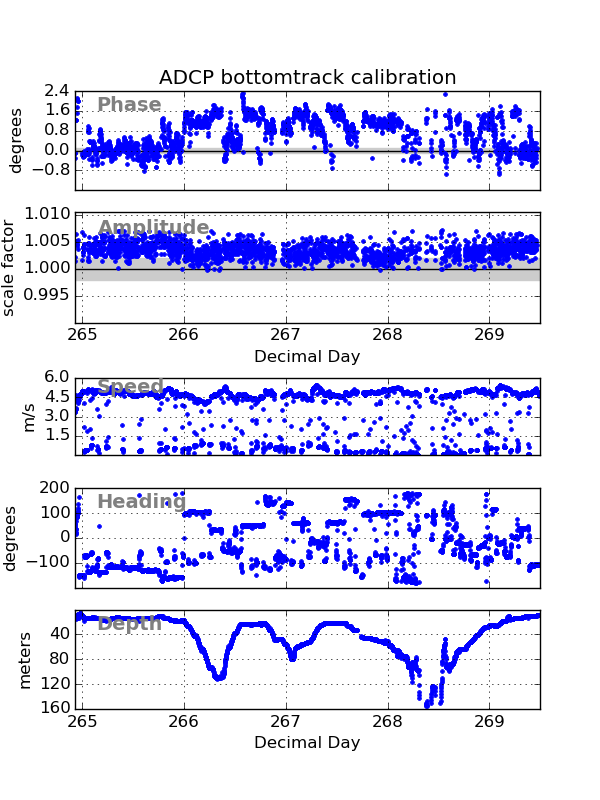

In [17]:
# Look at this phase correction
name = os.path.join(procpath, 'cal', 'botmtrk', 'btcal.png')
display(Image(name, width=600));

### Heading issue on Point Sur

There appears to be an on-going issue with ADCP data taken on the Point Sur with their heading data. A work-around follows.

1. undo automatic heading correction that was already applied by the system
1. use bottom tracking to fill in for bad heading correction

#### 1. undo automatic heading correction that was already applied by the system that was based on hcorr

These are the steps taken below:

1. make a copy of directory for preservation
1. unrotate data
1. rerun calibration without bad heading correction applied


In [18]:
# 1.
procpath_unrotated = os.path.join(procpathroot, 'wh300.unrotated')
!cp -r $procpath $procpath_unrotated

dbpath = os.path.join(procpath_unrotated, 'adcpdb', 'a_ps')

In [19]:
# Giving database location relative to this notebook
text = ' DB_NAME:       ' + dbpath + '\n'
text +=''' LOG_FILE:      rotate.log
           TIME_RANGE:    all

           OPTION_LIST:
              water_and_bottom_track:
                year_base=          2017
                unrotate!
                amplitude=          1.0
                angle_0=            0.0
                end
              end
'''

# create helper file to unrotate data
f = open(os.path.join(procpath_unrotated, 'cal', 'rotate', 'unrotate.tmp'), 'w')
f.write(text)
f.close()

In [20]:
# 2.
path = os.path.join(procpath_unrotated, 'cal', 'rotate', 'unrotate.tmp')
!rotate $path  # unrotate

INFO: database /Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated/adcpdb/a_ps opened

--------
 Pass 1: Checking control file...
--------
INFO: DBSRCH search beyond end
INFO: DBMOVE search beyond end
% OPTIONS:
% =======
% water_and_bottom_track:% OPTIONS:
% =======
% year_base= 2017
% unrotate!
% amplitude= 1.000000
% angle_0= 0.000000
% =======

% =======
INFO: DBSRCH search beyond end

--------
 Pass 2: Updating database...
--------
% OPTIONS:
% =======
% water_and_bottom_track:% OPTIONS:
% =======
% year_base= 2017
% unrotate!
% amplitude= 1.000000
% angle_0= 0.000000
% =======

% =======

 Processing range:  2017/09/22 22:14:00 to 2017/09/27 11:59:00

 END OF DATABASE

INFO: database closed




We need to see that Pass 2 occurred for this to have worked properly. So this is good. The data in `~/*.unrotated` is now unrotated.

Now we can rerun the calibration

In [21]:
# 3.
%cd $procpath_unrotated
!quick_adcp.py --steps2rerun navsteps:calib --auto  # redo calibration without rotation
%cd-

/Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated
sys.argv = /Users/kthyng/miniconda3/envs/adcp/bin/quick_adcp.py --steps2rerun navsteps:calib --auto
found dbinfo.txt: use values if otherwise unspecified
found dbname a_ps
fix file is a_ps.gps
reflayer: ref_method = refsm
reflayer: refuv_source = nav
reflayer: refuv_smoothwin = 3
importing numpy version 1.11.3
importing matplotlib version 1.5.1
found steps2rerun: navsteps:calib
===========  new run: steps2rerun====================
command line was: /Users/kthyng/miniconda3/envs/adcp/bin/quick_adcp.py --steps2rerun navsteps:calib --auto
cwd is /Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated
about to run these steps:
 - navsteps
 - calib
 - adcpsect
 - refabs
 - smoothnav
 - putnav
 - refplots
 - codaseditsetup
looking for database with adcpdb/a_ps*.blk
database found: listing blocks
database time range:
2017/09/22  22:14:17 to 2017/09/27  11:58:31
(264.926586 to 

We can compare the bottom track calibration files from each directory to see that the unrotation has occurred, as shown below. We are just noting that the phases are different in the two bottom track calibration files; we still need to address the phase problem.

In [22]:
# look at bottom track calibration for phase correction
print('Automatically rotated, original case:\n')
path = os.path.join(procpath, 'cal', 'botmtrk', 'btcaluv.out')
!tail -5 $path  

print('\n\nNew unrotated case:\n')
path = os.path.join(procpath_unrotated, 'cal', 'botmtrk', 'btcaluv.out')
!tail -5 $path  


Automatically rotated, original case:

edited:   2184 points, 2.0 min speed, 2.5 max dev
            median     mean      std
amplitude   1.0034   1.0034   0.0013
phase       0.7871   0.7054   0.6563



New unrotated case:

edited:   2178 points, 2.0 min speed, 2.5 max dev
            median     mean      std
amplitude   1.0034   1.0034   0.0013
phase       2.2731   2.1428   0.5897



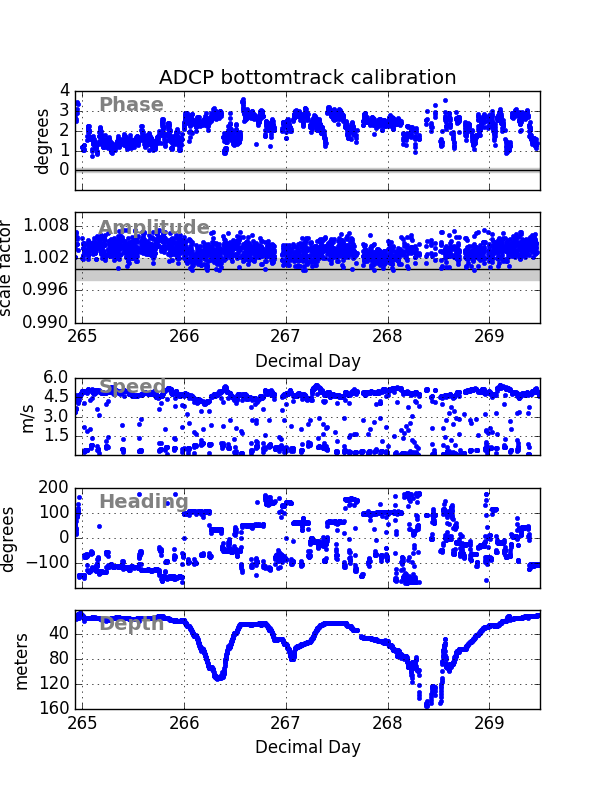

In [23]:
# Look at this phase correction
name = os.path.join(procpath_unrotated, 'cal', 'botmtrk', 'btcal.png')
display(Image(name, width=600));

#### 2. use bottom tracking to fill in for bad heading correction

1. Calculate the relationship between heading and phase using `fix_phase.use_model()`. This uses a previously-calculated model that fits a sine wave to other PS18_09_Leg*_DiMarco cruise Point Sur data. This previous model was calculated in `fix_phase.find_model()` and was saved so that it can be used in other cases. This assumes that this relationship will be similar on different cruises. Output the calculated relationship to be applied to data.
1. try applying the phase corrections in positive and negative direction to see which is correct



/Users/kthyng/Documents/projects/adcp_processing/ptsur_model

in Q_mpl


/Users/kthyng/miniconda3/envs/adcp/lib/python2.7/site-packages/pycurrents/adcp/quick_mpl.py:1247: RuntimeWarning: divide by zero encountered in true_divide
  self.a = self.speed_nav/self.speed_btgrid;
/Users/kthyng/miniconda3/envs/adcp/lib/python2.7/site-packages/pycurrents/adcp/quick_mpl.py:1247: RuntimeWarning: invalid value encountered in true_divide
  self.a = self.speed_nav/self.speed_btgrid;
/Users/kthyng/miniconda3/envs/adcp/lib/python2.7/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/kthyng/miniconda3/envs/adcp/lib/python2.7/site-packages/pycurrents/adcp/quick_mpl.py:1263: RuntimeWarning: invalid value encountered in greater
  self.a_ma[a_dev > self.max_sig] = ma.masked
/Users/kthyng/miniconda3/envs/adcp/lib/python2.7/site-packages/pycurrents/adcp/quick_mpl.py:1269: RuntimeWarning: invalid value encountered in greater
  badmask = (a_dev > self.max_sig) | (ph_d

/Users/kthyng/Documents/projects/adcp_processing/processed_data/ps1809l1


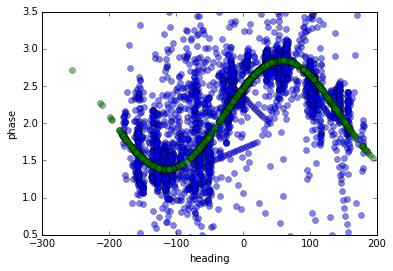

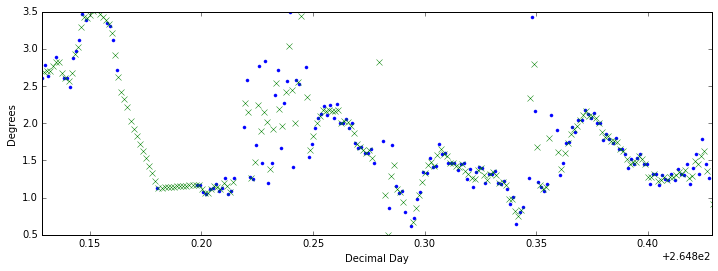

In [24]:
# 1. 
pathmodel = os.path.join('..', '..', 'ptsur_model')
%cd $pathmodel
import fix_phase
fix_phase.use_model(procpath_unrotated)
%cd-

Since the modeled phase fit (green, top figure) captures the existing data (blue) pretty well, and the calculated phases match the existing phase where it exists and fills in between, things are looking pretty good.

The modeled phases with decimal days are now saved into files `cal/rotate/btphase_positive.ang` and `cal/rotate/btphase_negative.ang`

In [25]:
# 2. apply the phase corrections in negative direction first to see if results are improved

# copy unrotated data directory to have a new place to work
procpath_unrotated_phaseneg = os.path.join(procpathroot, device + '.unrotated.phaseneg')
!cp -r $procpath_unrotated $procpath_unrotated_phaseneg

# put together a file to use in rotation
# time_angle_file is set to the phase correction we just created
dbpath = os.path.join(procpath_unrotated_phaseneg, 'adcpdb', 'a_ps')
filepath = os.path.join(procpath_unrotated_phaseneg, 'cal', 'rotate', 'rotate_btphase_negative')
text = ' DB_NAME:       ' + dbpath + '\n'
text +=''' LOG_FILE:      rotate.log
           TIME_RANGE:    all

           OPTION_LIST:
              water_and_bottom_track:
                year_base=          2017'''
text += '\ntime_angle_file:  ' + filepath + '.ang'
text += '''     amplitude=          1.0
                angle_0=            0.0
                end
              end
'''

# create helper file to unrotate data
filepathtmp = filepath + '.tmp'
f = open(filepathtmp, 'w')
f.write(text)
f.close()

# Apply this rotation correction
!rotate $filepathtmp  # unrotate


INFO: database /Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phaseneg/adcpdb/a_ps opened

--------
 Pass 1: Checking control file...
--------
INFO: DBSRCH search beyond end
INFO: DBMOVE search beyond end
% OPTIONS:
% =======
% water_and_bottom_track:% OPTIONS:
% =======
% year_base= 2017
% time_angle_file:                                                                                                                                                                                                                                                                                                                                                                                         /Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phaseneg/cal/rotate/rotate_btphase_negative.ang
% amplitude= 1.000000
% angle_0= 0.000000
% =======

% =======
INFO: DBMOVE search beyond end
INFO: DBSRCH search beyond end

--------
 Pass

In [26]:
# redo calibration
%cd $procpath_unrotated_phaseneg
!quick_adcp.py --steps2rerun navsteps:calib --auto
%cd-

/Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phaseneg
sys.argv = /Users/kthyng/miniconda3/envs/adcp/bin/quick_adcp.py --steps2rerun navsteps:calib --auto
found dbinfo.txt: use values if otherwise unspecified
fix file is a_ps.gps
reflayer: ref_method = refsm
reflayer: refuv_source = nav
reflayer: refuv_smoothwin = 3
importing numpy version 1.11.3
importing matplotlib version 1.5.1
found steps2rerun: navsteps:calib
===========  new run: steps2rerun====================
command line was: /Users/kthyng/miniconda3/envs/adcp/bin/quick_adcp.py --steps2rerun navsteps:calib --auto
cwd is /Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phaseneg
about to run these steps:
 - navsteps
 - calib
 - adcpsect
 - refabs
 - smoothnav
 - putnav
 - refplots
 - codaseditsetup
looking for database with adcpdb/a_ps*.blk
database found: listing blocks
database time range:
2017/09/22  22:14:17 to 2017/09/27  11:58:31
(264.926586 to 

In [27]:
# look at bottom track calibration for phase correction
print('Unrotated case:\n')
path = os.path.join(procpath_unrotated, 'cal', 'botmtrk', 'btcaluv.out')
!tail -5 $path  

print('\n\nAfter phase correction:\n')
path = os.path.join(procpath_unrotated_phaseneg, 'cal', 'botmtrk', 'btcaluv.out')
!tail -5 $path  


Unrotated case:

edited:   2178 points, 2.0 min speed, 2.5 max dev
            median     mean      std
amplitude   1.0034   1.0034   0.0013
phase       2.2731   2.1428   0.5897



After phase correction:

edited:   2179 points, 2.0 min speed, 2.5 max dev
            median     mean      std
amplitude   1.0034   1.0034   0.0013
phase       4.5191   4.2852   1.1121



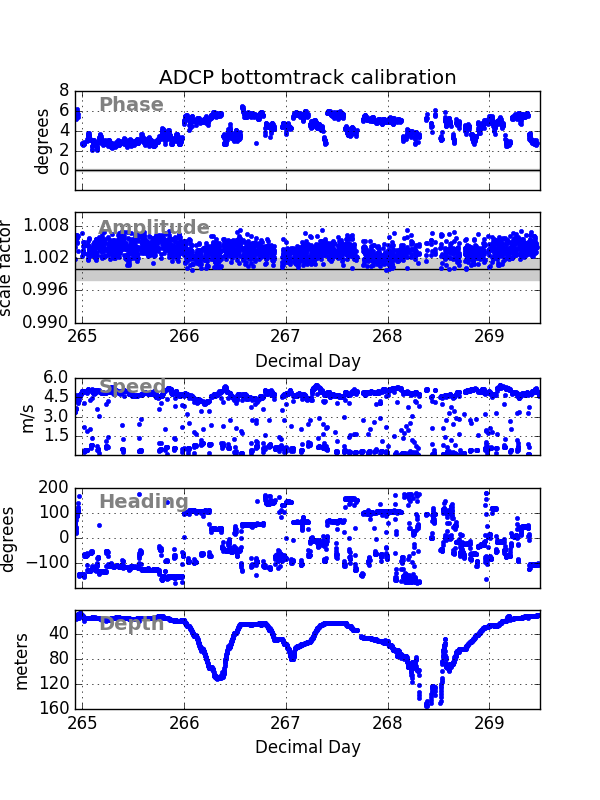

In [28]:
# Look at this phase correction
name = os.path.join(procpath_unrotated_phaseneg, 'cal', 'botmtrk', 'btcal.png')
display(Image(name, width=600));

The phase difference after the negative phase correction is worse, so let's try correcting in the positive direction instead.

In [29]:
# 2. apply the phase corrections in positive direction first to see if results are improved

# copy unrotated data directory to have a new place to work
procpath_unrotated_phasepos = os.path.join(procpathroot, device + '.unrotated.phasepos')
!cp -r $procpath_unrotated $procpath_unrotated_phasepos

# put together a file to use in rotation
# time_angle_file is set to the phase correction we just created
dbpath = os.path.join(procpath_unrotated_phasepos, 'adcpdb', 'a_ps')
filepath = os.path.join(procpath_unrotated_phasepos, 'cal', 'rotate', 'rotate_btphase_positive')
text = ' DB_NAME:       ' + dbpath + '\n'
text +=''' LOG_FILE:      rotate.log
           TIME_RANGE:    all

           OPTION_LIST:
              water_and_bottom_track:
                year_base=          2017'''
text += '\ntime_angle_file:  ' + filepath + '.ang'
text += '''     amplitude=          1.0
                angle_0=            0.0
                end
              end
'''

# create helper file to unrotate data
filepathtmp = filepath + '.tmp'
f = open(filepathtmp, 'w')
f.write(text)
f.close()

# Apply this rotation correction
!rotate $filepathtmp

INFO: database /Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phasepos/adcpdb/a_ps opened

--------
 Pass 1: Checking control file...
--------
INFO: DBSRCH search beyond end
INFO: DBMOVE search beyond end
% OPTIONS:
% =======
% water_and_bottom_track:% OPTIONS:
% =======
% year_base= 2017
% time_angle_file:                                                                                                                                                                                                                                                                                                                                                                                         /Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phasepos/cal/rotate/rotate_btphase_positive.ang
% amplitude= 1.000000
% angle_0= 0.000000
% =======

% =======
INFO: DBMOVE search beyond end
INFO: DBSRCH search beyond end

--------
 Pass

In [30]:
# redo calibration
%cd $procpath_unrotated_phasepos
!quick_adcp.py --steps2rerun navsteps:calib --auto
%cd-

/Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phasepos
sys.argv = /Users/kthyng/miniconda3/envs/adcp/bin/quick_adcp.py --steps2rerun navsteps:calib --auto
found dbinfo.txt: use values if otherwise unspecified
fix file is a_ps.gps
reflayer: ref_method = refsm
reflayer: refuv_source = nav
reflayer: refuv_smoothwin = 3
importing numpy version 1.11.3
importing matplotlib version 1.5.1
found steps2rerun: navsteps:calib
===========  new run: steps2rerun====================
command line was: /Users/kthyng/miniconda3/envs/adcp/bin/quick_adcp.py --steps2rerun navsteps:calib --auto
cwd is /Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phasepos
about to run these steps:
 - navsteps
 - calib
 - adcpsect
 - refabs
 - smoothnav
 - putnav
 - refplots
 - codaseditsetup
looking for database with adcpdb/a_ps*.blk
database found: listing blocks
database time range:
2017/09/22  22:14:17 to 2017/09/27  11:58:31
(264.926586 to 

In [31]:
# look at bottom track calibration for phase correction
print('Unrotated case:\n')
path = os.path.join(procpath_unrotated, 'cal', 'botmtrk', 'btcaluv.out')
!tail -5 $path  

print('\n\nAfter phase correction:\n')
path = os.path.join(procpath_unrotated_phasepos, 'cal', 'botmtrk', 'btcaluv.out')
!tail -5 $path  


Unrotated case:

edited:   2178 points, 2.0 min speed, 2.5 max dev
            median     mean      std
amplitude   1.0034   1.0034   0.0013
phase       2.2731   2.1428   0.5897



After phase correction:

edited:   2097 points, 2.0 min speed, 2.5 max dev
            median     mean      std
amplitude   1.0034   1.0034   0.0013
phase      -0.0330  -0.0109   0.2442



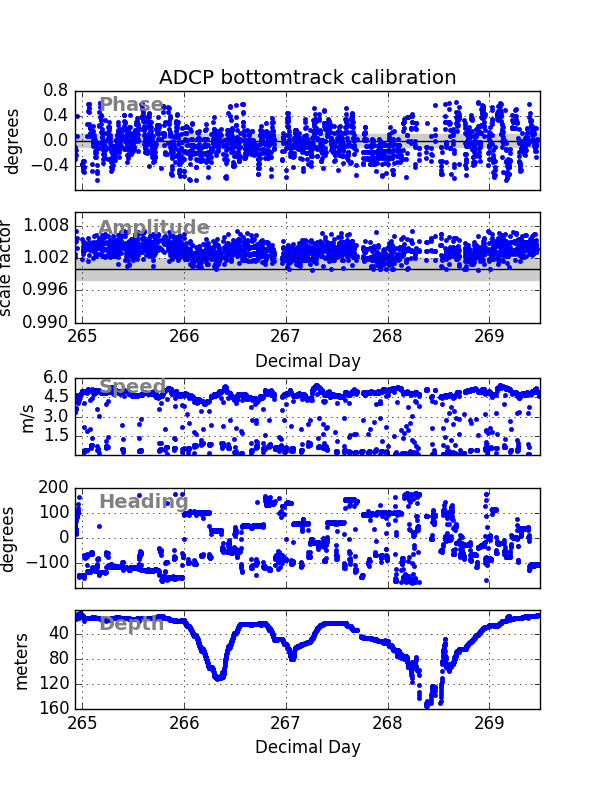

In [32]:
# Look at this phase correction
name = os.path.join(procpath_unrotated_phasepos, 'cal', 'botmtrk', 'btcal.png')
display(Image(name, width=600));

Now the phase is much closer to zero! This is close enough to call good. We will move forward with this data directory.

## (3) check calibration:

### (a) Check ~/cal/watertrk/adcpcal.out for amplitude issues

The water track calculation is best to check for amplitude issues (bottom track better for phase, if you have it. We already did that).

In [33]:
path = os.path.join(procpath_unrotated_phasepos, 'cal', 'watertrk', 'adcpcal.out')
!tail -10 $path

   phase =   0.15  + -0.1064 (t - 267.4)
            median     mean      std
amplitude   1.0080   1.0078   0.0074
phase       0.0380   0.1470   0.5182
nav - pc    1.0000   0.5210   3.5459
var         0.0010   0.0030   0.0087
min var     0.0010   0.0018   0.0023
delta-u     0.2000   0.0339   3.5266
delta-v     0.0500   0.0103   3.3303



This shows that a small amplitude correction is needed, which we will apply now.

In [34]:
# Here you can interact with data
# dv $procpath_unrotated_phasepos --startdday=266.1 -s 0.5

The offset in amplitude seems to be visible when the ship heading changes in particular, such as just to the right of the red bar in the image below. In the gui version of the dataviewer (which is run in the cell above), this can be seen by adding the ship heading and speed to the plot.

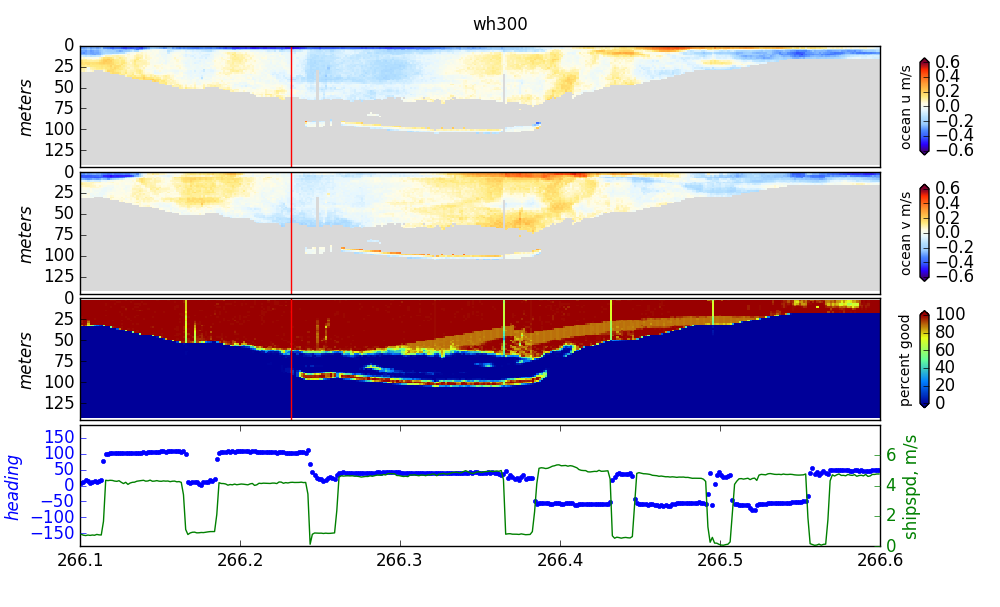

In [35]:
display(Image('https://user-images.githubusercontent.com/3487237/31913254-4abf1cc2-b80c-11e7-810f-39edc23ca604.png'))

In [36]:
# copy new data directory
procpath_unrotated_phasepos_amp = os.path.join(procpathroot, device + '.unrotated.phasepos.amp')
!cp -r $procpath_unrotated_phasepos $procpath_unrotated_phasepos_amp

# can do recalibration with amplitude offset inline since it is a constant
%cd $procpath_unrotated_phasepos_amp
!quick_adcp.py --steps2rerun rotate:apply_edit:navsteps:calib --rotate_amplitude 1.008 --auto
%cd-

/Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phasepos.amp
sys.argv = /Users/kthyng/miniconda3/envs/adcp/bin/quick_adcp.py --steps2rerun rotate:apply_edit:navsteps:calib --rotate_amplitude 1.008 --auto
found dbinfo.txt: use values if otherwise unspecified
fix file is a_ps.gps
reflayer: ref_method = refsm
reflayer: refuv_source = nav
reflayer: refuv_smoothwin = 3
importing numpy version 1.11.3
importing matplotlib version 1.5.1
found steps2rerun: rotate:apply_edit:navsteps:calib
===========  new run: steps2rerun====================
command line was: /Users/kthyng/miniconda3/envs/adcp/bin/quick_adcp.py --steps2rerun rotate:apply_edit:navsteps:calib --rotate_amplitude 1.008 --auto
cwd is /Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phasepos.amp
about to run these steps:
 - rotate
 - apply_edit
 - navsteps
 - calib
 - adcpsect
 - refabs
 - smoothnav
 - putnav
 - refplots
 - codaseditsetup
looking for databas

In [37]:
# check water track calibration:
path = os.path.join(procpath_unrotated_phasepos_amp, 'cal', 'watertrk', 'adcpcal.out')
!tail -10 $path

   phase =   0.15  + -0.1065 (t - 267.4)
            median     mean      std
amplitude   1.0000   0.9998   0.0074
phase       0.0410   0.1469   0.5191
nav - pc    0.0000   0.2353   3.1615
var         0.0010   0.0026   0.0085
min var     0.0010   0.0016   0.0025
delta-u     0.2000   0.0339   3.5266
delta-v     0.0500   0.0103   3.3303



So this is better, and very close to zero!

Now let's visually compare to see if the amplitude change across heading changes is smaller.

The flags are as follows:
-m5 for 5 minutes vectors, -n7 for 7 panels, -c for compare, 1st for better one, 2nd for worse comparison 

Have to change the depth range to be up to 150 meters.

In [38]:
# interact with data
# dv --startdday=266.1 -s 0.5 -m5 -n7 -c $procpath_unrotated_phasepos_amp $procpath_unrotated_phasepos

Now the offset in amplitude seems smaller. In the gui version of the dataviewer (which is run in the cell above), I changed the bottom panel to be the speed and heading of the ship.

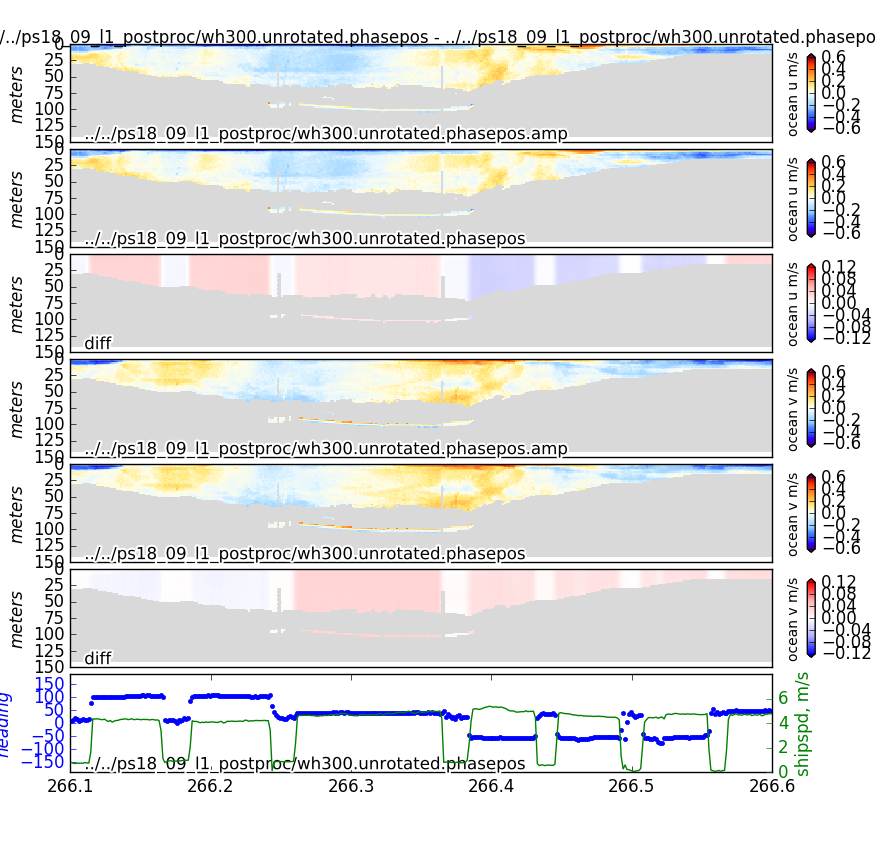

In [39]:
display(Image('https://user-images.githubusercontent.com/3487237/31913250-46f3267e-b80c-11e7-943f-71368b59b537.png'))

Already did (b) cal/botmtrk/btcaluv.out when we found the heading problems.

## (4) Try to edit bad data

Data looks pretty good based on what we've seen, so skip this.

## (5) [there is no 5]

## (6) look at data again to see if it looks OK (more editing needed?)

already did this

## (7) make web plots

I didn't end up using this. Supposed to get `webpy/index.html` and view with browser but didn't get `index.html`.


In [40]:
# %cd $procpath_unrotated_phasepos_amp
# !quick_web.py --redo --interactive
# %cd-

## (8) extract data

End up with netCDF and .mat files located in `~/contour/`.

In [41]:
%cd $procpath_unrotated_phasepos_amp
outpath = os.path.join('contour', device)
!adcp_nc.py adcpdb $outpath $cruiseid $device
!quick_adcp.py --steps2rerun matfiles --auto

/Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phasepos.amp
test your file by running 

  ncdump -h contour/wh300.nc


sys.argv = /Users/kthyng/miniconda3/envs/adcp/bin/quick_adcp.py --steps2rerun matfiles --auto
found dbinfo.txt: use values if otherwise unspecified
fix file is a_ps.gps
reflayer: ref_method = refsm
reflayer: refuv_source = nav
reflayer: refuv_smoothwin = 3
importing numpy version 1.11.3
importing matplotlib version 1.5.1
found steps2rerun: matfiles
===========  new run: steps2rerun====================
command line was: /Users/kthyng/miniconda3/envs/adcp/bin/quick_adcp.py --steps2rerun matfiles --auto
cwd is /Users/kthyng/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phasepos.amp
about to run these steps:
 - matfiles
 - codaseditsetup
looking for database with adcpdb/a_ps*.blk
database found: listing blocks
database time range:
2017/09/22  22:14:17 to 2017/09/27  11:58:31
(264.926586 to 269.498970)
-----

In [42]:
# look at netCDF file contents
outpath = outpath + '.nc'
!ncdump -h $outpath
%cd-

netcdf wh300 {
dimensions:
	time = 3262 ;
	depth_cell = 70 ;
variables:
	int trajectory ;
		trajectory:standard_name = "trajectory_id" ;
	double time(time) ;
		time:long_name = "Decimal day" ;
		time:units = "days since 2017-01-01 00:00:00" ;
		time:C_format = "%12.5f" ;
		time:standard_name = "time" ;
		time:data_min = 264.926585648148 ;
		time:data_max = 269.498969907407 ;
	double lon(time) ;
		lon:missing_value = 1.e+38 ;
		lon:long_name = "Longitude" ;
		lon:units = "degrees_east" ;
		lon:C_format = "%9.4f" ;
		lon:standard_name = "longitude" ;
		lon:data_min = -97.2721583333333 ;
		lon:data_max = -93.5317722222222 ;
	double lat(time) ;
		lat:missing_value = 1.e+38 ;
		lat:long_name = "Latitude" ;
		lat:units = "degrees_north" ;
		lat:C_format = "%9.4f" ;
		lat:standard_name = "latitude" ;
		lat:data_min = 27.0930388888889 ;
		lat:data_max = 29.4916805555556 ;
	float depth(time, depth_cell) ;
		depth:missing_value = 1.e+38f ;
		depth:long_name = "Depth" ;
		depth:units = "meter" ;


/Users/kthyng/Documents/projects/adcp_processing/processed_data/ps1809l1


So, here is the difference between the cleaned up and the original data:

In [43]:
# Interact with data
# dv --startdday=266.1 -s 0.5 -m5 -n7 -c $procpath_unrotated_phasepos_amp $procpath

Here is a comparison of the final product compared with it unprocessed.

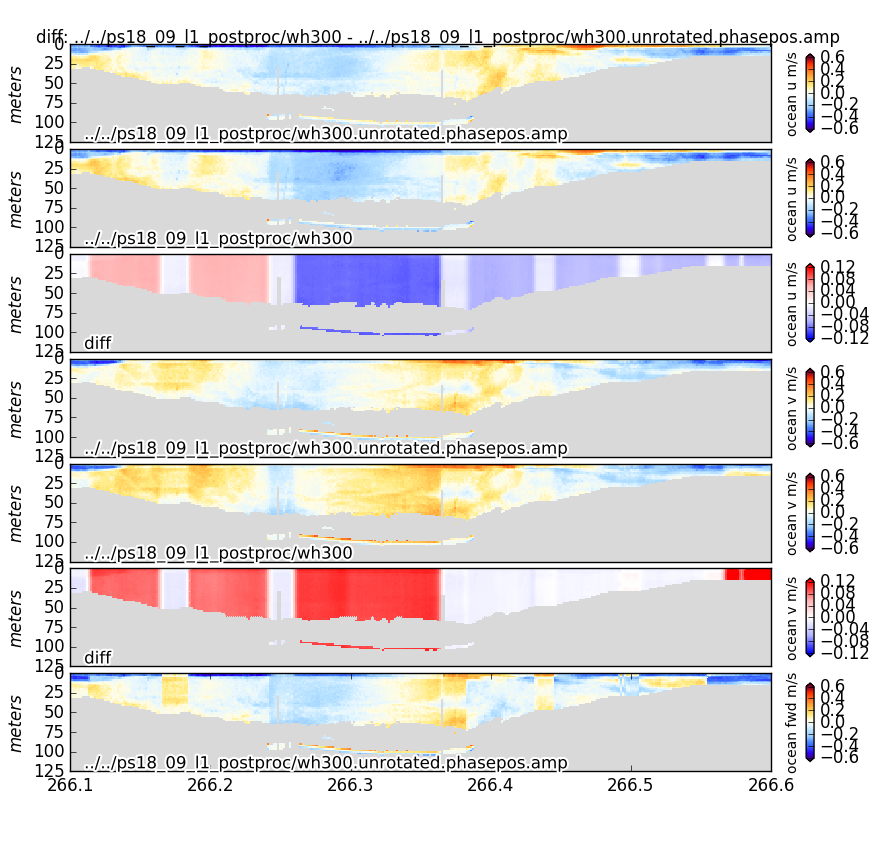

In [44]:
display(Image('https://user-images.githubusercontent.com/3487237/31913222-2fdd5022-b80c-11e7-9dcf-89e94fc44e17.png'))

In [45]:
# interact with data
# dv -s 0.5 -m5 -n2 -c $procpath_unrotated_phasepos_amp $procpath

Images from the data:

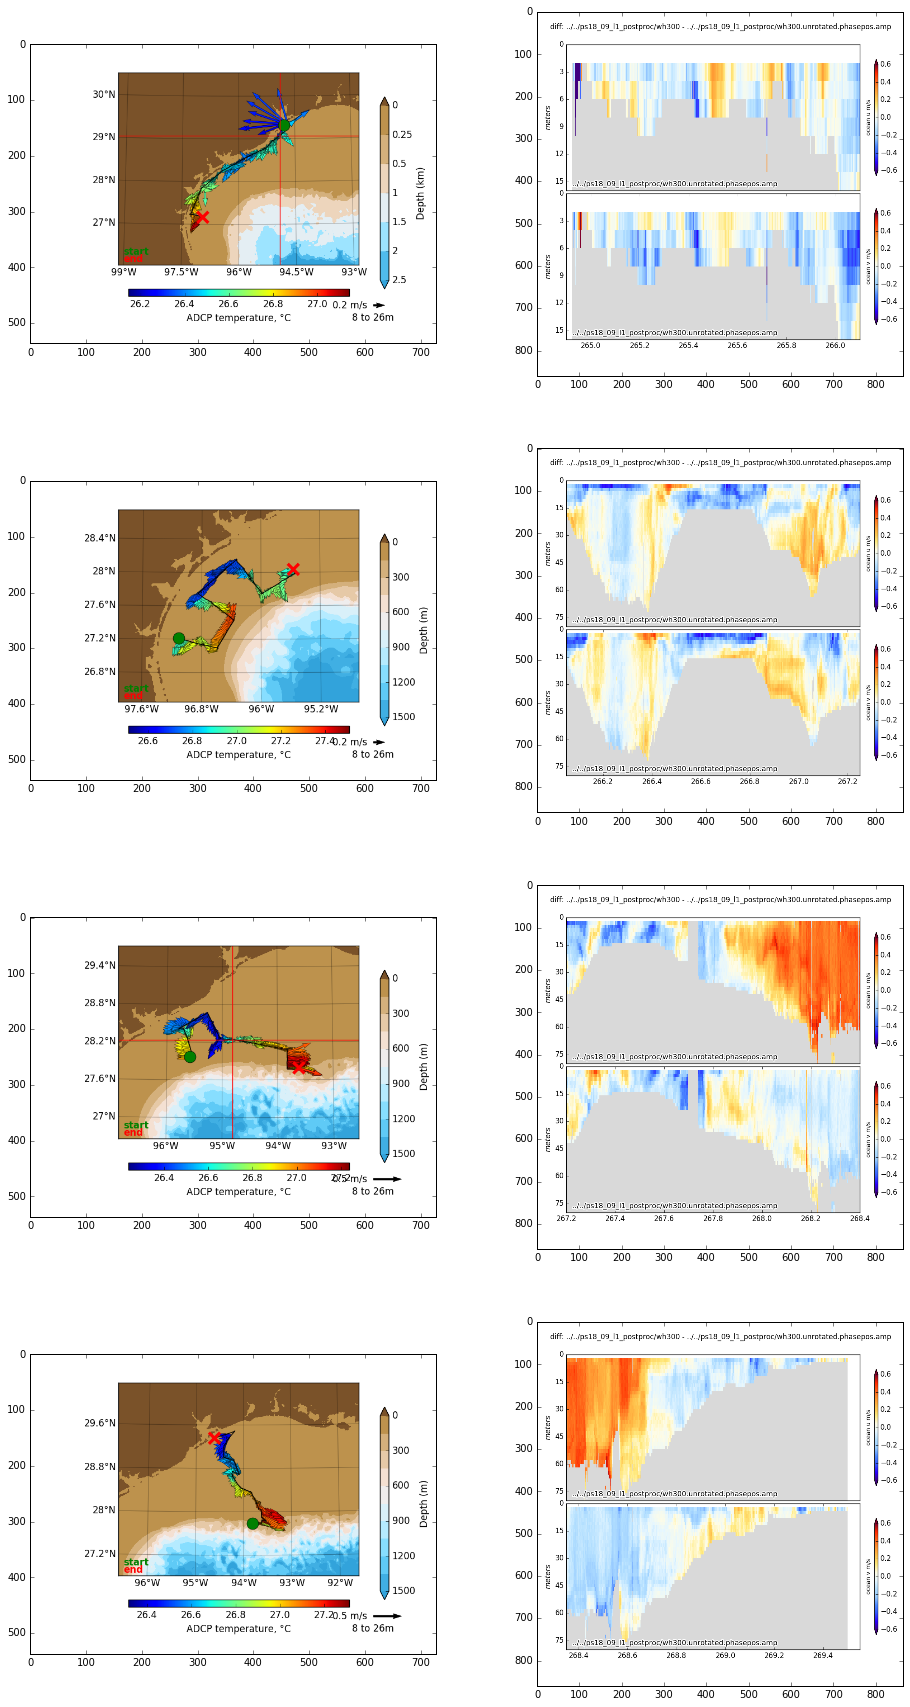

In [46]:
mapnames = ['https://user-images.githubusercontent.com/3487237/31913285-64703e6c-b80c-11e7-8dd3-c912d0b3b778.png',
           'https://user-images.githubusercontent.com/3487237/31913298-6bb5cd7c-b80c-11e7-8ce1-63b96c1fe450.png',
           'https://user-images.githubusercontent.com/3487237/31913303-6efbc8ec-b80c-11e7-967a-601d5a6c97b7.png',
           'https://user-images.githubusercontent.com/3487237/31913305-6f4ce47a-b80c-11e7-9391-04d98049a3c1.png']
datanames = ['https://user-images.githubusercontent.com/3487237/31913281-613dd4c0-b80c-11e7-99e1-8bebc32e6074.png',
            'https://user-images.githubusercontent.com/3487237/31913291-68134046-b80c-11e7-9534-c0470eaa499a.png',
            'https://user-images.githubusercontent.com/3487237/31913302-6ed98b24-b80c-11e7-897c-a56da64a1d01.png',
            'https://user-images.githubusercontent.com/3487237/31913304-6f13ed50-b80c-11e7-8df9-0c3386425b28.png']

fig, axes = plt.subplots(len(mapnames), 2, figsize=(16,30))
for i, (mapname, dataname) in enumerate(zip(mapnames, datanames)):
    axes[i,0].imshow(plt.imread(mapname))
    axes[i,1].imshow(plt.imread(dataname))